# MLP para series de tiempo

Trabajaremos con un conjunto de datos de clima global para predecir la temperatura promedio diaria en Nueva York utilizando un modelo de Perceptrón Multicapa (MLP).

Descarga el dataset desde **`global_weather_data_2015_2024.csv`** y actualiza la ruta del archivo en la primera celda de código.

In [1]:
import pandas as pd

# Leer el archivo CSV (actualiza esta ruta a donde descargues el archivo)
file_path = "global_weather_data_2015_2024.csv"
data = pd.read_csv(file_path, encoding='latin1')

# Mostrar las primeras filas y columnas disponibles
print(data.head())
print(data.columns)

                  date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  \
0  2015-01-02 00:00:00  11.1   NaN   NaN   NaN   NaN   NaN   5.4   NaN   NaN   
1  2015-01-03 00:00:00  11.3   6.7  18.8   NaN   NaN   NaN   1.4   NaN   NaN   
2  2015-01-04 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  2015-01-05 00:00:00  10.9   5.7  17.8   NaN   NaN   NaN   7.4   NaN   NaN   
4  2015-01-06 00:00:00  11.1   NaN   NaN   NaN   NaN   NaN   8.7   NaN   NaN   

   tsun       city   country  
0   NaN  Islamabad  Pakistan  
1   NaN  Islamabad  Pakistan  
2   NaN  Islamabad  Pakistan  
3   NaN  Islamabad  Pakistan  
4   NaN  Islamabad  Pakistan  
Index(['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun', 'city', 'country'],
      dtype='object')


In [2]:
# Filtrar por USA y luego por la ciudad de New York
usa_data = data[data['country'] == 'USA']
new_york_data = usa_data[usa_data['city'] == 'New York']
print(new_york_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3649 entries, 21894 to 25542
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     3649 non-null   object 
 1   tavg     3649 non-null   float64
 2   tmin     3649 non-null   float64
 3   tmax     3649 non-null   float64
 4   prcp     3649 non-null   float64
 5   snow     3649 non-null   float64
 6   wdir     0 non-null      float64
 7   wspd     3649 non-null   float64
 8   wpgt     0 non-null      float64
 9   pres     3649 non-null   float64
 10  tsun     1 non-null      float64
 11  city     3649 non-null   object 
 12  country  3649 non-null   object 
dtypes: float64(10), object(3)
memory usage: 399.1+ KB
None


In [3]:
# Definir índice temporal y extraer la serie de temperatura promedio (tavg)
new_york_data = new_york_data.copy()
new_york_data.set_index('date', inplace=True)
new_york_tavg = new_york_data['tavg']
print(new_york_tavg.head())

date
2015-01-02 00:00:00    2.6
2015-01-03 00:00:00    0.9
2015-01-04 00:00:00    6.6
2015-01-05 00:00:00    5.4
2015-01-06 00:00:00   -6.4
Name: tavg, dtype: float64


## EDA (Exploración de datos)

In [4]:
# Estadísticas descriptivas básicas de la serie
new_york_tavg.describe()

count    3649.000000
mean       13.995122
std         9.634669
min       -13.200000
25%         6.200000
50%        14.000000
75%        22.800000
max        33.200000
Name: tavg, dtype: float64

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Gráfico interactivo de la serie temporal
fig = px.line(new_york_tavg, title="Temperatura promedio en Nueva York", labels={"value": "Temperatura", "date": "Fecha"})
fig.update_layout(xaxis_title="Fecha", yaxis_title="Temperatura promedio (°C)")
fig.show()

In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Descomposición de la serie temporal (verifica que el índice sea de frecuencia diaria)
decomposition = seasonal_decompose(new_york_tavg, model='additive', period=365)

# Crear subgráficos
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=("Tendencia", "Estacionalidad", "Residuo"))

# Agregar la tendencia
fig.add_trace(go.Scatter(x=new_york_tavg.index, y=decomposition.trend, mode='lines', name='Tendencia'),
              row=1, col=1)

# Agregar la estacionalidad
fig.add_trace(go.Scatter(x=new_york_tavg.index, y=decomposition.seasonal, mode='lines', name='Estacionalidad'),
              row=2, col=1)

# Agregar el residuo
fig.add_trace(go.Scatter(x=new_york_tavg.index, y=decomposition.resid, mode='lines', name='Residuo'),
              row=3, col=1)

# Actualizar el diseño
fig.update_layout(title="Descomposición de la serie temporal",
                  xaxis_title="Fecha",
                  height=800,
                  showlegend=False)
fig.show()

<Figure size 1200x600 with 0 Axes>

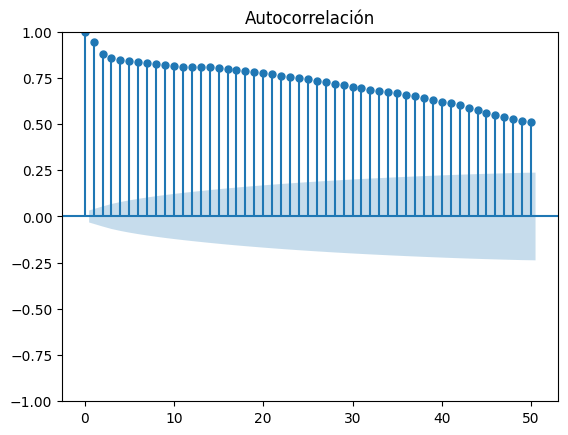

<Figure size 1200x600 with 0 Axes>

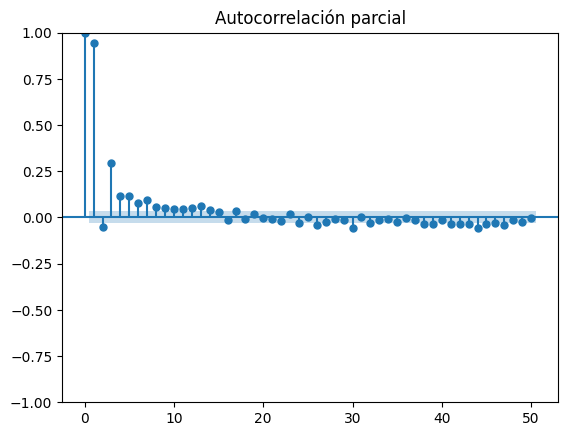

In [7]:
# Análisis de autocorrelación y autocorrelación parcial
plt.figure(figsize=(12, 6))
plot_acf(new_york_tavg.dropna(), lags=50, title="Autocorrelación")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(new_york_tavg.dropna(), lags=50, title="Autocorrelación parcial")
plt.show()

Las gráficas suelen mostrar una serie con fuerte memoria temporal y tendencia persistente, típica de variables climáticas. La PACF puede sugerir un comportamiento autorregresivo de primer orden, por lo que el modelo debe incluir el rezago inmediato y, potencialmente, componentes estacionales de mayor plazo.